In [252]:
import gzip
import numpy as np
import math
import matplotlib.pyplot as plt

In [253]:
# import mnist
f = gzip.open('./train-images-idx3-ubyte.gz','r')
image_size = 28
num_images = 60000
buf = f.read(image_size * image_size * num_images)
X_train = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
X_train = X_train.reshape(num_images, image_size*image_size)

f = gzip.open('./train-labels-idx1-ubyte.gz','r')  
buf = f.read(60000)
y_train = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)

f = gzip.open('./t10k-images-idx3-ubyte.gz','r')
image_size = 28
num_images = 10000
buf = f.read(image_size * image_size * num_images)
X_test = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
X_test = X_test.reshape(num_images, image_size*image_size, 1)

f = gzip.open('./train-labels-idx1-ubyte.gz','r')  
buf = f.read(60000)
y_test = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)

In [254]:
# class name 0-9
cla = [0,1,2,3,4,5,6,7,8,9]

In [255]:
# calculate info of class
mean = [] # list of mean of class
cov = [] # list of mean of covariance matrix of class
for class_name in cla:
    temp = X_train[y_train==class_name] # class i (number i)
    temp_mean = temp.mean(axis=0) # calculate mean
    mean.append(temp_mean)
    temp_cov = np.cov(X_train[y_train==0].T) # calculate covairance
    cov.append(temp_cov)

In [256]:
def cal_eigen(h):
    # calculate modify covariance
    modify_covmatrix = []
    for cov_ in cov:
        cov_modefied = cov_ + h * h * np.identity(784)
        modify_covmatrix.append(cov_modefied)

    # calculate eigenvalues and eigenvectors
    eigvals_list = []
    eigvecs_list = []
    for i in range(10):
        eigvals, eigvecs = np.linalg.eig(modify_covmatrix[i])
        eigvals_list.append(eigvals)
        eigvecs_list.append(eigvecs)
    return eigvals_list, eigvecs_list

In [257]:
# classify test data one by one
def point_classification(x, eigvals_list, eigvecs_list):
    class_value = [] # list of class
    for i in range(10):
        # calculate MADF by class
        eigvals, eigvecs = eigvals_list[i], eigvecs_list[i] # calculate eigenvalue and eigenvector
        mean[i].resize(784,1)
        mqdf = 0
        a = x-mean[i]
        for j in range(len(eigvals)):
            dot = 0
            for jj in range(784):
                dot += a[jj] * eigvecs[j][jj]
            mqdf -= dot ** 2 / abs(eigvals[j])
            mqdf -= math.log(abs(eigvals[j]))
        class_value.append(mqdf)
    result_x = class_value.index(max(class_value)) # calculate class has max value
    return result_x

In [258]:
# calculate accuracy using test data
def predict(h):
    eigvals_list, eigvecs_list = cal_eigen(h)
    right_num = 0 # number of right calssified data
    test_result = [] # store test result
    for i in range(10000):
        x = X_test[i]
        result = point_classification(x, eigvals_list, eigvecs_list)
        if result == y_test[i]:
            right_num += 1
        test_result.append(result)
    score = right_num / 10000
    return score, test_result

In [259]:
# hyperparameter (h) tuning
h_list = [i/100 for i in range(1,10)]
score_list = []
test_result_list = []
for h in h_list:
    score, test_result = predict(h)
    score_list.append(score)
    test_result_list.append(test_result)

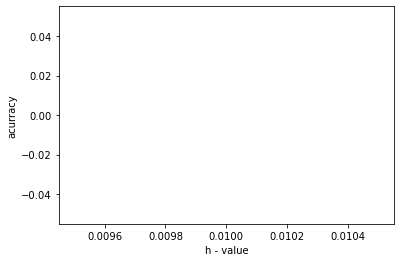

In [261]:
# save result as png
plt.plot(h_list, score_list)
plt.xlabel('h - value')
plt.ylabel('acurracy')
plt.savefig('result.png')

In [264]:
# you can choose best h-value using result.png